# Démo  — Classification de textures (CNN + LBP-HF)

Ce notebook reproduit l'évaluation complète du modèle hybride sans nécessiter le dataset complet d'images brutes (plusieurs Go).

**Contenu du notebook**
1. **Chargement des features** : Lecture de `features_all.npz` avec métadonnées samples
2. **Visualisations pédagogiques** :
   - Analyse LBP-HF : invariance à la rotation (spectre de Fourier)
   - Activations CNN ResNet18 : cartes de features conv1
3. **Évaluation LOSO** : Validation croisée Leave-One-Sample-Out (4 folds)
4. **Matrice de confusion** : Visualisation des taux de reconnaissance par classe

**Résultats attendus**
- Accuracy moyenne : **~81.6% ± 2.9%**
- F1-score pondéré : **~80.3% ± 2.5%**

## **1. Chargement des features**

In [2]:
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement du fichier features_all.npz
NPZ_PATH = Path('data') / 'features_all.npz'

assert NPZ_PATH.exists(), f"Le fichier {NPZ_PATH} n'existe pas."

# Chargement des données
data = np.load(NPZ_PATH, allow_pickle=True)
X = data['X']
y = data['y']
classes = data['classes']
samples = data['samples']  # Métadonnées des samples (a/b/c/d) déjà alignées

print(f"✓ Features chargées : {X.shape[0]} vecteurs de {X.shape[1]} dimensions")
print(f"✓ Classes : {list(classes)}")
print(f"✓ Répartition par sample :")
unique, counts = np.unique(samples, return_counts=True)
for s, c in zip(unique, counts):
    print(f"  - {s}: {c} vecteurs")

X.shape, y.shape, len(classes)

✓ Features chargées : 9504 vecteurs de 517 dimensions
✓ Classes : ['aluminium_foil', 'brown_bread', 'corduroy', 'cork', 'cotton', 'cracker', 'lettuce_leaf', 'linen', 'white_bread', 'wood', 'wool']
✓ Répartition par sample :
  - sample_a: 2376 vecteurs
  - sample_b: 2376 vecteurs
  - sample_c: 2376 vecteurs
  - sample_d: 2376 vecteurs


((9504, 517), (9504,), 11)

## 2. **Visualisation des descripteurs (exemples illustratifs)**

Les cellules suivantes démontrent le comportement des descripteurs LBP-HF et CNN face aux rotations.

### **Example 1 : Lettuce leaf**

c:\Users\Raouf\Desktop\M1SI\Image\Projet Image\projet_hybride_cnn_lbp\env_cnn_lbp\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


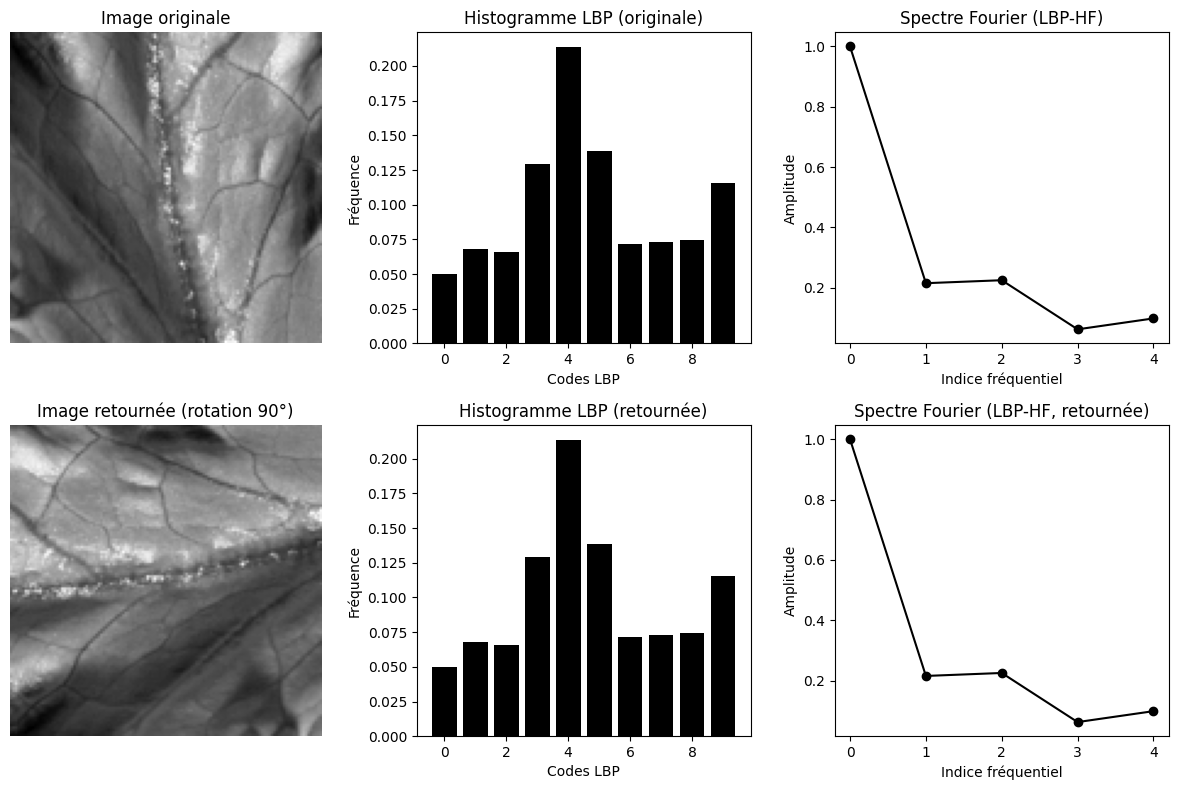

In [3]:
# Visualisation LBP-HF : invariance à la rotation
from skimage.feature import local_binary_pattern
from PIL import Image

# Charger une texture en niveaux de gris
img_path_gray = Path('data') / 'sample_images' / 'lettuce_leaf_sample_b_00164.png'
img_gray = np.array(Image.open(img_path_gray).convert("L"), dtype=np.float32)

# Créer une version pivotée (90°)
img_rot = np.array(Image.open(img_path_gray).convert("L").transpose(Image.ROTATE_90), dtype=np.float32)

# Paramètres du LBP
P, R = 8, 1

def lbp_hf_analysis(img_gray):
    lbp = local_binary_pattern(img_gray, P=P, R=R, method='uniform')
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    fft_vals = np.fft.fft(hist)
    mag = np.abs(fft_vals[:len(fft_vals)//2])
    return lbp, hist, mag

lbp1, hist1, mag1 = lbp_hf_analysis(img_gray)
lbp2, hist2, mag2 = lbp_hf_analysis(img_rot)

# Visualisation 2×3
plt.figure(figsize=(12,8))

# Image originale
plt.subplot(2,3,1)
plt.imshow(img_gray, cmap='gray')
plt.title("Image originale")
plt.axis("off")

plt.subplot(2,3,2)
plt.bar(range(len(hist1)), hist1, color='black')
plt.title("Histogramme LBP (originale)")
plt.xlabel("Codes LBP"); plt.ylabel("Fréquence")

plt.subplot(2,3,3)
plt.plot(mag1, 'ko-')
plt.title("Spectre Fourier (LBP-HF)")
plt.xlabel("Indice fréquentiel"); plt.ylabel("Amplitude")

# Image retournée
plt.subplot(2,3,4)
plt.imshow(img_rot, cmap='gray')
plt.title("Image retournée (rotation 90°)")
plt.axis("off")

plt.subplot(2,3,5)
plt.bar(range(len(hist2)), hist2, color='black')
plt.title("Histogramme LBP (retournée)")
plt.xlabel("Codes LBP"); plt.ylabel("Fréquence")

plt.subplot(2,3,6)
plt.plot(mag2, 'ko-')
plt.title("Spectre Fourier (LBP-HF, retournée)")
plt.xlabel("Indice fréquentiel"); plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

### Observations sur LBP-HF et invariance à la rotation

**Image originale vs image rotée (90°)** :
- **Histogrammes LBP** : Les distributions de codes LBP changent entre l'originale et la version retournée, car les patterns binaires locaux sont sensibles à l'orientation.
- **Spectres de Fourier (LBP-HF)** : Les magnitudes du spectre restent **très similaires** malgré la rotation. C'est la propriété clé du descripteur LBP-HF : la transformée de Fourier rend l'histogramme invariant aux permutations circulaires des bins, capturant ainsi l'information de texture indépendamment de l'orientation.

**Conclusion** : Le descripteur LBP-HF extrait des caractéristiques robustes à la rotation tout en préservant la structure locale de la texture.

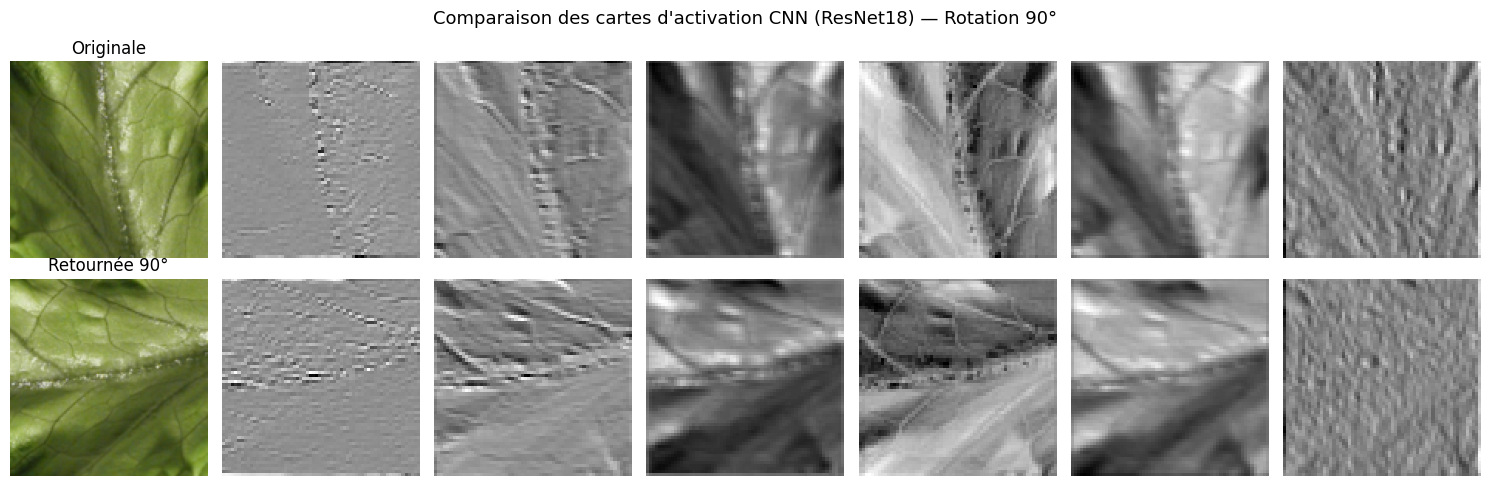

In [5]:
# Visualisation CNN : activations ResNet18
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Charger une texture RGB
img_path_rgb = Path('data') / 'sample_images' / 'lettuce_leaf_sample_b_00164.png'
img = Image.open(img_path_rgb).convert("RGB")
img_rot = img.transpose(Image.ROTATE_90)

# Prétraitement ImageNet
tfm = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
x1 = tfm(img).unsqueeze(0)
x2 = tfm(img_rot).unsqueeze(0)

# Charger ResNet18
cnn_viz = models.resnet18(weights="IMAGENET1K_V1")
cnn_viz.eval()

# Extraire les activations de la première couche convolutionnelle
with torch.no_grad():
    f1 = cnn_viz.conv1(x1).squeeze().cpu().numpy()
    f2 = cnn_viz.conv1(x2).squeeze().cpu().numpy()

# Visualisation des 6 premières cartes d'activation
plt.figure(figsize=(15,5))

# Image originale + activations
plt.subplot(2,7,1)
plt.imshow(img)
plt.title("Originale")
plt.axis("off")

for i in range(6):
    plt.subplot(2,7,i+2)
    plt.imshow(f1[i], cmap='gray')
    plt.axis('off')

# Image retournée + activations
plt.subplot(2,7,8)
plt.imshow(img_rot)
plt.title("Retournée 90°")
plt.axis("off")

for i in range(6):
    plt.subplot(2,7,i+9)
    plt.imshow(f2[i], cmap='gray')
    plt.axis('off')

plt.suptitle("Comparaison des cartes d'activation CNN (ResNet18) — Rotation 90°", fontsize=13)
plt.tight_layout()
plt.show()

### Observations sur CNN ResNet18 et sensibilité à la rotation

**Image originale vs image rotée (90°)** :
- **Cartes d'activation (conv1)** : Les 6 premières feature maps montrent des réponses différentes entre l'image originale et sa version retournée. Les filtres convolutionnels détectent des motifs orientés (bords verticaux, horizontaux, diagonales).
- **Sensibilité à l'orientation** : Contrairement au LBP-HF, le CNN n'est **pas nativement invariant** à la rotation. Les activations changent significativement car les poids du réseau sont appris sur ImageNet avec des orientations canoniques.

**Complémentarité CNN + LBP-HF** :
- Le **CNN** capture des structures globales et des patterns sémantiques de haut niveau.
- Le **LBP-HF** apporte l'invariance locale à la rotation par construction théorique.
- Leur **fusion** combine robustesse globale (CNN + augmentation) et invariance locale (LBP-HF).

### **Example 2 : Corduroy**

c:\Users\Raouf\Desktop\M1SI\Image\Projet Image\projet_hybride_cnn_lbp\env_cnn_lbp\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


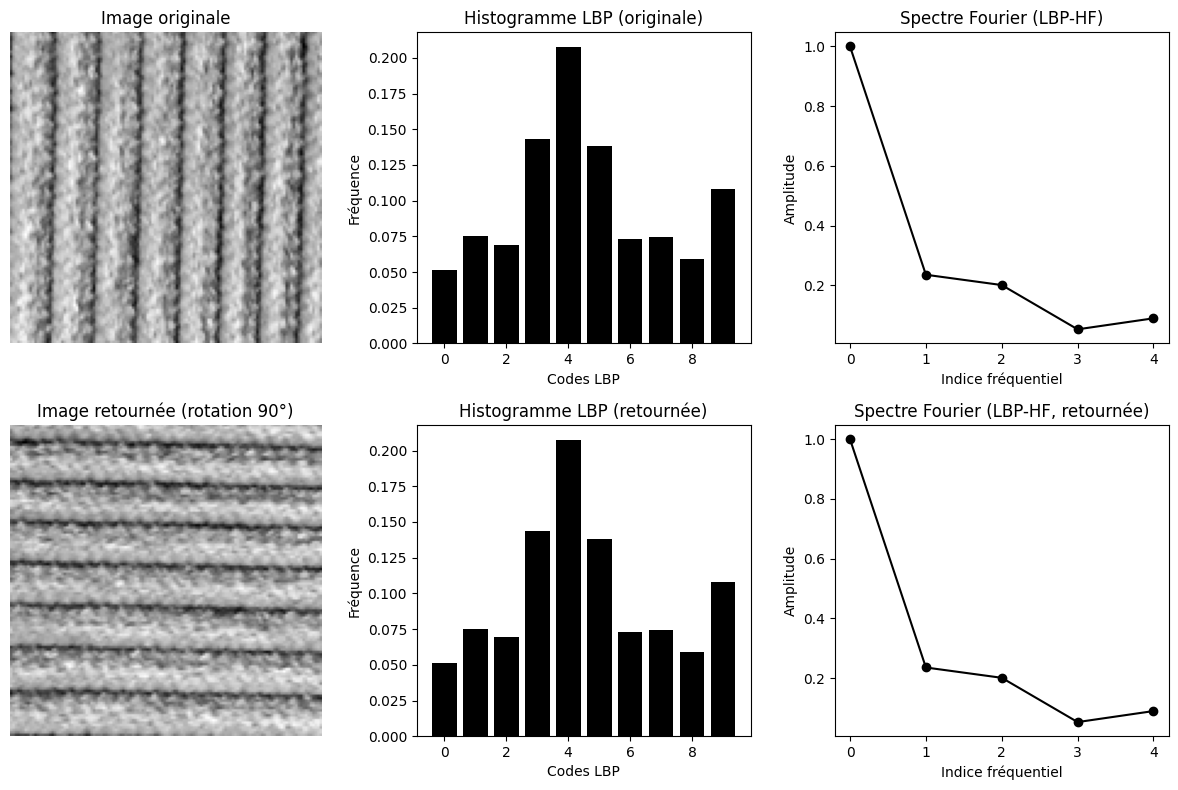

In [6]:
# Visualisation LBP-HF : invariance à la rotation
from skimage.feature import local_binary_pattern
from PIL import Image

# Charger une texture en niveaux de gris
img_path_gray = Path('data') / 'sample_images' / 'corduroy_sample_a_00032.png'
img_gray = np.array(Image.open(img_path_gray).convert("L"), dtype=np.float32)

# Créer une version pivotée (90°)
img_rot = np.array(Image.open(img_path_gray).convert("L").transpose(Image.ROTATE_90), dtype=np.float32)

# Paramètres du LBP
P, R = 8, 1

def lbp_hf_analysis(img_gray):
    lbp = local_binary_pattern(img_gray, P=P, R=R, method='uniform')
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    fft_vals = np.fft.fft(hist)
    mag = np.abs(fft_vals[:len(fft_vals)//2])
    return lbp, hist, mag

lbp1, hist1, mag1 = lbp_hf_analysis(img_gray)
lbp2, hist2, mag2 = lbp_hf_analysis(img_rot)

# Visualisation 2×3
plt.figure(figsize=(12,8))

# Image originale
plt.subplot(2,3,1)
plt.imshow(img_gray, cmap='gray')
plt.title("Image originale")
plt.axis("off")

plt.subplot(2,3,2)
plt.bar(range(len(hist1)), hist1, color='black')
plt.title("Histogramme LBP (originale)")
plt.xlabel("Codes LBP"); plt.ylabel("Fréquence")

plt.subplot(2,3,3)
plt.plot(mag1, 'ko-')
plt.title("Spectre Fourier (LBP-HF)")
plt.xlabel("Indice fréquentiel"); plt.ylabel("Amplitude")

# Image retournée
plt.subplot(2,3,4)
plt.imshow(img_rot, cmap='gray')
plt.title("Image retournée (rotation 90°)")
plt.axis("off")

plt.subplot(2,3,5)
plt.bar(range(len(hist2)), hist2, color='black')
plt.title("Histogramme LBP (retournée)")
plt.xlabel("Codes LBP"); plt.ylabel("Fréquence")

plt.subplot(2,3,6)
plt.plot(mag2, 'ko-')
plt.title("Spectre Fourier (LBP-HF, retournée)")
plt.xlabel("Indice fréquentiel"); plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

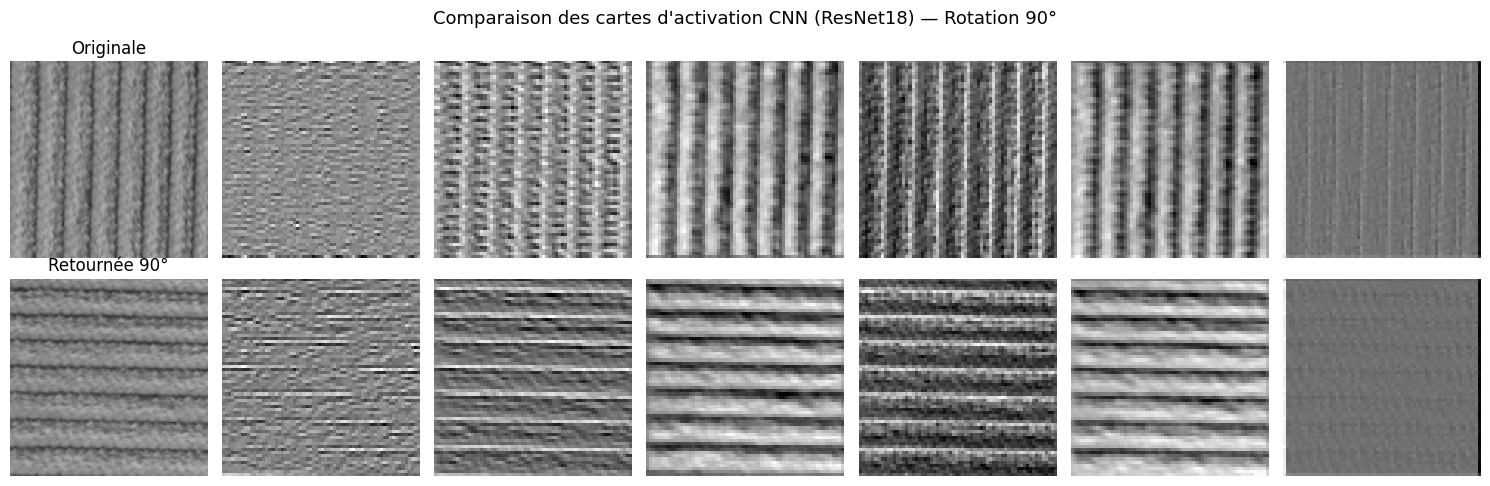

In [ ]:
# Visualisation CNN : activations ResNet18
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Charger une texture RGB
img_path_rgb = Path('sample_images') / 'corduroy_sample_a_gray_00032.png'
img = Image.open(img_path_rgb).convert("RGB")
img_rot = img.transpose(Image.ROTATE_90)

# Prétraitement ImageNet
tfm = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
x1 = tfm(img).unsqueeze(0)
x2 = tfm(img_rot).unsqueeze(0)

# Charger ResNet18
cnn_viz = models.resnet18(weights="IMAGENET1K_V1")
cnn_viz.eval()

# Extraire les activations de la première couche convolutionnelle
with torch.no_grad():
    f1 = cnn_viz.conv1(x1).squeeze().cpu().numpy()
    f2 = cnn_viz.conv1(x2).squeeze().cpu().numpy()

# Visualisation des 6 premières cartes d'activation
plt.figure(figsize=(15,5))

# Image originale + activations
plt.subplot(2,7,1)
plt.imshow(img)
plt.title("Originale")
plt.axis("off")

for i in range(6):
    plt.subplot(2,7,i+2)
    plt.imshow(f1[i], cmap='gray')
    plt.axis('off')

# Image retournée + activations
plt.subplot(2,7,8)
plt.imshow(img_rot)
plt.title("Retournée 90°")
plt.axis("off")

for i in range(6):
    plt.subplot(2,7,i+9)
    plt.imshow(f2[i], cmap='gray')
    plt.axis('off')

plt.suptitle("Comparaison des cartes d'activation CNN (ResNet18) — Rotation 90°", fontsize=13)
plt.tight_layout()
plt.show()

## 3. **Évaluation LOSO**

In [7]:
def run_loso(X, y, samples, classes):
    folds = ['sample_a','sample_b','sample_c','sample_d']
    accs, f1s = [], []
    cms = []
    for held in folds:
        test_mask = samples == held
        if test_mask.sum() == 0:
            continue
        train_mask = ~test_mask
        Xtr, Xte = X[train_mask], X[test_mask]
        ytr, yte = y[train_mask], y[test_mask]

        scaler = StandardScaler().fit(Xtr)
        Xtr_s = scaler.transform(Xtr)
        Xte_s = scaler.transform(Xte)

        clf = SVC(kernel='rbf', C=10, gamma='scale')
        clf.fit(Xtr_s, ytr)
        yhat = clf.predict(Xte_s)

        acc = accuracy_score(yte, yhat)
        f1w = f1_score(yte, yhat, average='weighted')
        accs.append(acc); f1s.append(f1w)

        cm = confusion_matrix(yte, yhat, labels=range(len(classes)))
        cms.append(cm)
        print(f"Fold {held} — Acc: {acc*100:.2f}% | F1w: {f1w*100:.2f}% | n={len(yte)}")
    return accs, f1s, cms

accs, f1s, cms = run_loso(X, y, samples, classes)
print(f"\nMoyenne Accuracy: {np.mean(accs)*100:.2f}% ± {np.std(accs)*100:.2f}%")
print(f"Moyenne F1-weighted: {np.mean(f1s)*100:.2f}% ± {np.std(f1s)*100:.2f}%")

Fold sample_a — Acc: 84.26% | F1w: 82.80% | n=2376
Fold sample_b — Acc: 83.59% | F1w: 80.30% | n=2376
Fold sample_c — Acc: 81.82% | F1w: 81.83% | n=2376
Fold sample_d — Acc: 76.85% | F1w: 76.35% | n=2376

Moyenne Accuracy: 81.63% ± 2.90%
Moyenne F1-weighted: 80.32% ± 2.46%


## 4. **Matrice de confusion**

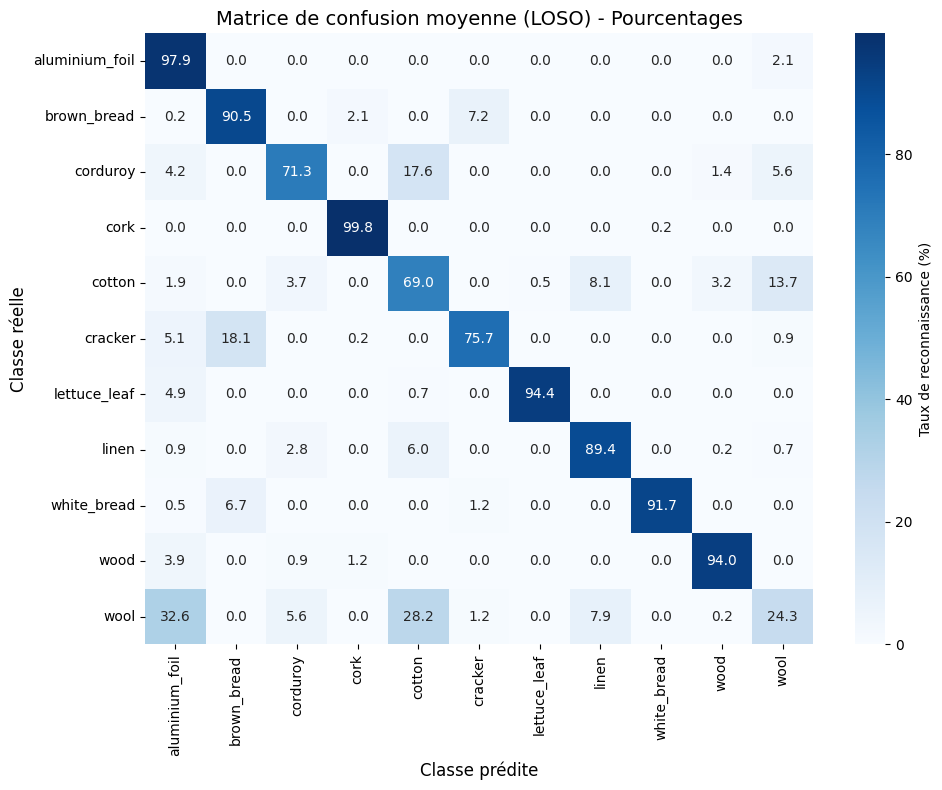

In [8]:
# Matrice de confusion moyenne avec pourcentages
import numpy.typing as npt

def mean_confusion(cms: list[npt.NDArray]) -> np.ndarray:
    stacked = np.stack(cms, axis=0).astype(float)
    return np.nanmean(stacked, axis=0)

if cms:
    cm_avg = mean_confusion(cms)
    # Normalisation en pourcentages (par ligne = par classe réelle)
    cm_percent = cm_avg / cm_avg.sum(axis=1, keepdims=True) * 100
    
    plt.figure(figsize=(10,8))
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Taux de reconnaissance (%)'})
    plt.title('Matrice de confusion moyenne (LOSO) - Pourcentages', fontsize=14)
    plt.xlabel('Classe prédite', fontsize=12)
    plt.ylabel('Classe réelle', fontsize=12)
    plt.tight_layout()
    plt.show()